<h3> Overall Takeaways </h3>

Many different approaches to stock prediction, using a variety of types of datasets. Unfortunately, some of the approaches utilize concepts that will be covered later in the course, so for these approaches, I will summarize my learnings for the future, when I'm able to implement these approaches.

<ol>
  <li> Stock prediction using traditional ML approaches and quantitative data - Stefan Jansen </li>
    Many different approaches outlined in his textbook, however, I will start with RNN on S&P 500 data to predict the price. <br />
  https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/19_recurrent_neural_nets/01_univariate_time_series_regression.ipynb
  <li> Stock prediction using financial news and technical + fundamental data - Astock dataset </li>
  While I do not feel like I have the tools to pursue this approach at the moment, I believe that my final project should include at least one NLP approach, and this is one such example. I will summarize (to the best of my abilities) the approach and the results in this PapersWithCode project on using financial news.
  <li> Twitter based NLP? </li>
  https://github.com/yumoxu/stocknet-dataset
</ol>


In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

<h3> Approach One: RNN </h3>

Following the approach laid out by stefan jansen, we use RNN to predict time series data of the S&P 500.

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

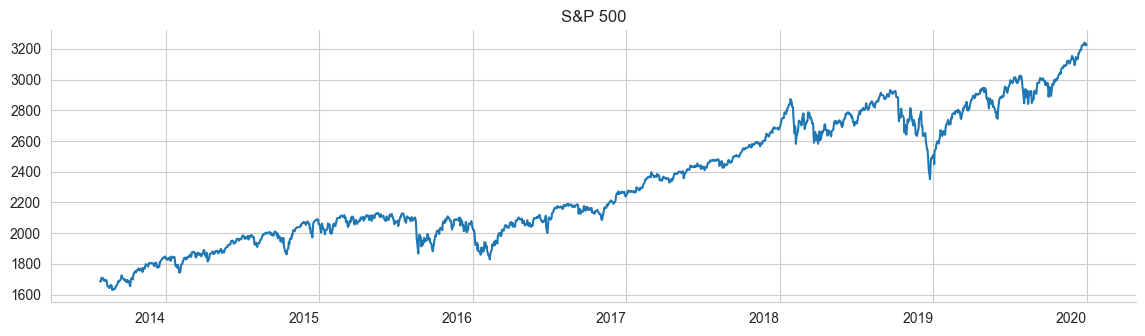

In [25]:
### Import Data from Federal Reserve Bank’s Data Service FRED ###

sp500 = web.DataReader('SP500', 'fred', start='2010', end='2020').dropna()
ax = sp500.plot(title='S&P 500',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()

In [26]:
### Function to create univariate time series data for training an RNN model ###

def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [27]:
### Normalize Data ###
scaler = MinMaxScaler()
sp500_scaled = pd.Series(scaler.fit_transform(sp500).squeeze(), 
                         index=sp500.index)

window_size = 63

### Create Data ###
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)

X.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
DATE,,,,,,,,,,,,,,,,,,,,,
2013-10-25,0.034078,0.034469,0.034327,0.047461,0.049200,0.047629,0.041558,0.037545,0.041627,0.037862,...,0.045181,0.049492,0.041987,0.056575,0.063788,0.070840,0.070940,0.077159,0.072008,0.075543
2013-10-28,0.034469,0.034327,0.047461,0.049200,0.047629,0.041558,0.037545,0.041627,0.037862,0.036650,...,0.049492,0.041987,0.056575,0.063788,0.070840,0.070940,0.077159,0.072008,0.075543,0.080327
2013-10-29,0.034327,0.047461,0.049200,0.047629,0.041558,0.037545,0.041627,0.037862,0.036650,0.039564,...,0.041987,0.056575,0.063788,0.070840,0.070940,0.077159,0.072008,0.075543,0.080327,0.081781
2013-10-30,0.047461,0.049200,0.047629,0.041558,0.037545,0.041627,0.037862,0.036650,0.039564,0.034115,...,0.056575,0.063788,0.070840,0.070940,0.077159,0.072008,0.075543,0.080327,0.081781,0.087895
2013-10-31,0.049200,0.047629,0.041558,0.037545,0.041627,0.037862,0.036650,0.039564,0.034115,0.019161,...,0.063788,0.070840,0.070940,0.077159,0.072008,0.075543,0.080327,0.081781,0.087895,0.082527


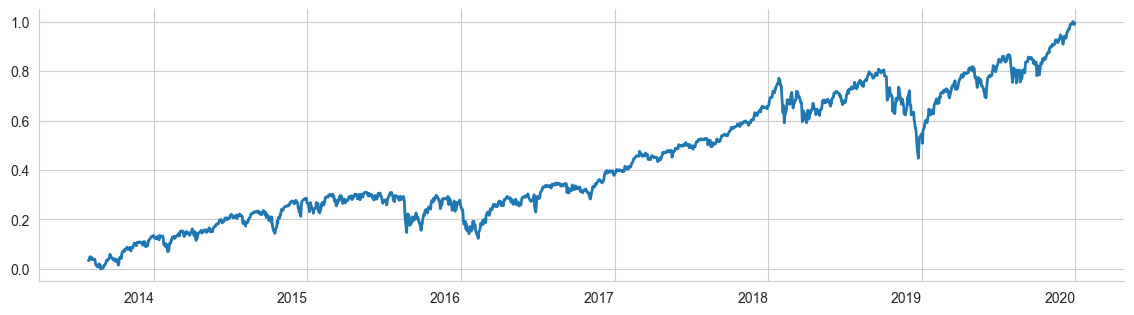

In [28]:
### View Data ###

ax = sp500_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [8]:
### Train-test split ###

X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)

### Train on data up to 2018 ###
X_train = X[:'2018'].values.reshape(-1, window_size, 1)
y_train = y[:'2018']

### Test on data from 2019 ###
X_test = X['2019':].values.reshape(-1, window_size, 1)
y_test = y['2019':]

n_obs, window_size, n_features = X_train.shape

y_train.shape

(1304,)

In [30]:
### Create RNN Model ###

rnn = Sequential([
    LSTM(units=10, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
### Define optimizer for RNN ###

optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

### Compile RNN w/ previously defined optimizer ###
rnn.compile(loss='mean_squared_error', 
            optimizer=optimizer)

### Save best path of model during training ###
rnn_path = (results_path / 'rnn.h5').as_posix()

### Call best model during training ###
checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

### Early stopping to prevent overfitting ###
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)

### Train model ###
lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=150,
                        batch_size=20,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer],
                        verbose=2)

Epoch 1/150

Epoch 1: val_loss improved from inf to 0.00027, saving model to results/univariate_time_series\rnn.h5
66/66 - 3s - loss: 2.3548e-04 - val_loss: 2.6582e-04 - 3s/epoch - 39ms/step
Epoch 2/150

Epoch 2: val_loss improved from 0.00027 to 0.00026, saving model to results/univariate_time_series\rnn.h5
66/66 - 1s - loss: 2.2989e-04 - val_loss: 2.5554e-04 - 734ms/epoch - 11ms/step
Epoch 3/150

Epoch 3: val_loss did not improve from 0.00026
66/66 - 1s - loss: 2.2925e-04 - val_loss: 0.0012 - 724ms/epoch - 11ms/step
Epoch 4/150

Epoch 4: val_loss did not improve from 0.00026
66/66 - 1s - loss: 2.2650e-04 - val_loss: 4.2049e-04 - 706ms/epoch - 11ms/step
Epoch 5/150

Epoch 5: val_loss did not improve from 0.00026
66/66 - 1s - loss: 2.1100e-04 - val_loss: 3.2568e-04 - 710ms/epoch - 11ms/step
Epoch 6/150

Epoch 6: val_loss improved from 0.00026 to 0.00024, saving model to results/univariate_time_series\rnn.h5
66/66 - 1s - loss: 2.1445e-04 - val_loss: 2.3603e-04 - 725ms/epoch - 11ms/step


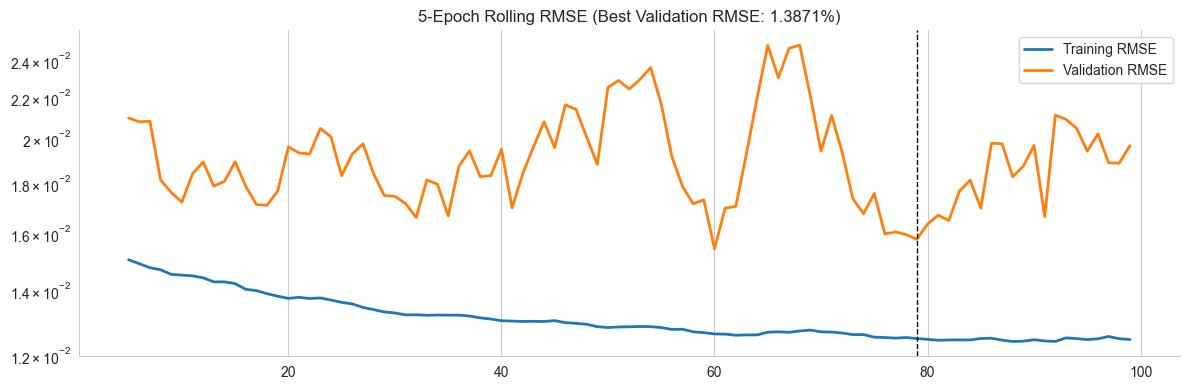

In [33]:
### Plot performance ###

fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_error', dpi=300)

In [17]:
### More performance benchmarks ###

train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0129 | Test RMSE: 0.0142


In [34]:
### We trained on scaled data, therefore our predictions are in scaled form ###
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

### Correlation coefficient between predicted and actual values ###
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

8/8 [==============================] - 0s 3ms/step
Train IC: 0.9960 | Test IC: 0.9817


<h3> Major Takeaways </h3>

This approach can be more broadly applied to a variety of quantitative data sources, using a variety of different model types. Fundamentally, this approach breaks down to utilizing a single stock, training on past data, and testing on the same stock data (of a more recent timeframe)
<br />
<br />
After speaking with my mentor, RNN appears to have fairly good performance, therefore we chose to pursue RNN as our first example. In future stages of the project, I will generalize/expand this approach to include different models and different data sources.


<h3> Approach 2: NLP </h3>
Although not directly a stock prediction, we explore how we can use NLP to do sentiment analysis on tweets. We do so following the methodology laid out by stefan jansen.

Notebook link: https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/14_working_with_text_data/05_sentiment_analysis_twitter.ipynb

<h3> Approach 3: Twitter based NLP </h3>

Here, we apply NLP to stock movement prediction. I don't quite have the skills to understand what's going on under the hood, so I will do my best to outline their approach and identify anything I can learn from the paper, and hopefully apply this to my final project down the line.

Link: https://github.com/yumoxu/stocknet-dataset